In [1]:
import os
import gc
import logging
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve, accuracy_score, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn import svm
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.base import clone

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn import cluster

In [2]:
%matplotlib inline

In [3]:
start_time = time.time()

In [4]:
train_df = pd.read_csv('../input/train.csv')

In [5]:
test_df = pd.read_csv('../input/test.csv')

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Columns: 202 entries, ID_code to var_199
dtypes: float64(200), int64(1), object(1)
memory usage: 308.2+ MB


In [7]:
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


In [8]:
train_df.shape

(200000, 202)

In [9]:
train_df.head()

,ID_code,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,train_0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,train_1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,train_2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,train_3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,train_4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104


In [10]:
train_df_id_droped = train_df[train_df.columns.drop('ID_code')]

In [11]:
train_df['var_0'].unique().shape

(94672,)

In [12]:
#train_df.apply(pd.unique, axis=0)

In [13]:
uniques_dict = {column_name: train_df_id_droped[column_name].unique() for column_name in train_df_id_droped.columns.drop('target').tolist()}

In [14]:
uniques_dict_counts = {column_name: uniques.shape[0] for column_name, uniques in uniques_dict.items()}

In [15]:
uniques_counts_series = pd.Series(uniques_dict_counts)

In [16]:
uniques_counts_series[:5]

var_0     94672
var_1    108932
var_2     86555
var_3     74597
var_4     63515
dtype: int64

In [17]:
uniques_counts_series.unique().shape

(200,)

In [18]:
uniques_counts_series.max()

169968

In [19]:
uniques_counts_series.min()

451

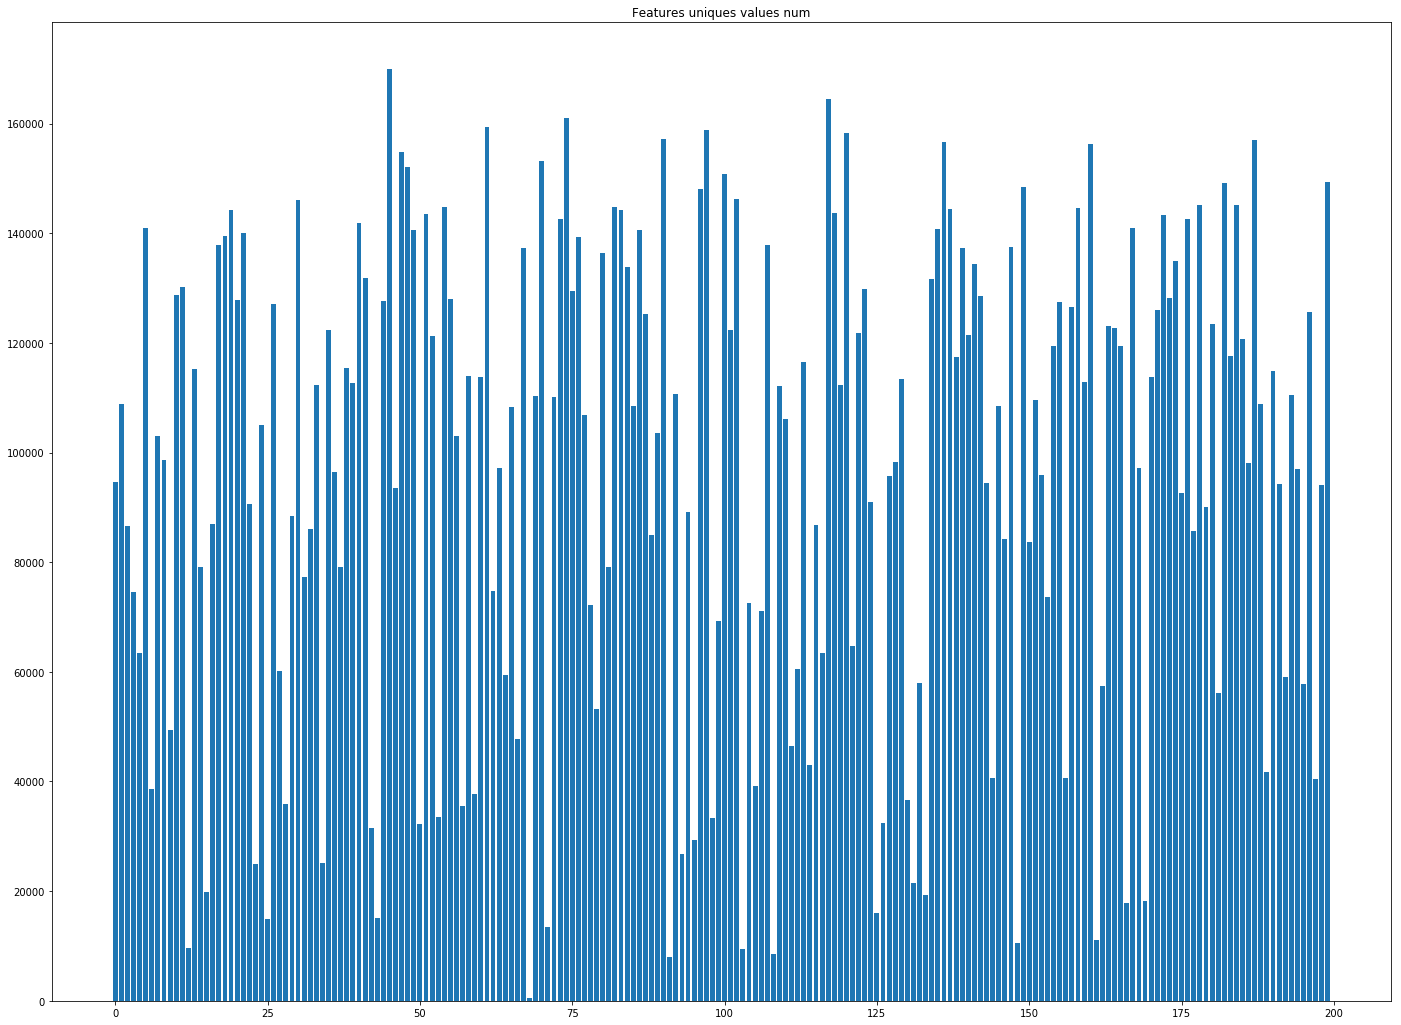

In [20]:
fig = plt.figure(figsize=(24, 18))
ax = fig.add_subplot(111)
ax.bar(np.arange(200), uniques_counts_series.values.astype(np.int64))
#ax.bar(uniques_counts_series)
ax.set_title('Features uniques values num')
plt.show()

In [21]:
all_cells_execution_time = time.time() - start_time
print("all cells execution time: {} min".format(all_cells_execution_time / 60))

all cells execution time: 0.3591361363728841 min


In [22]:
train_df_id_droped.shape

(200000, 201)

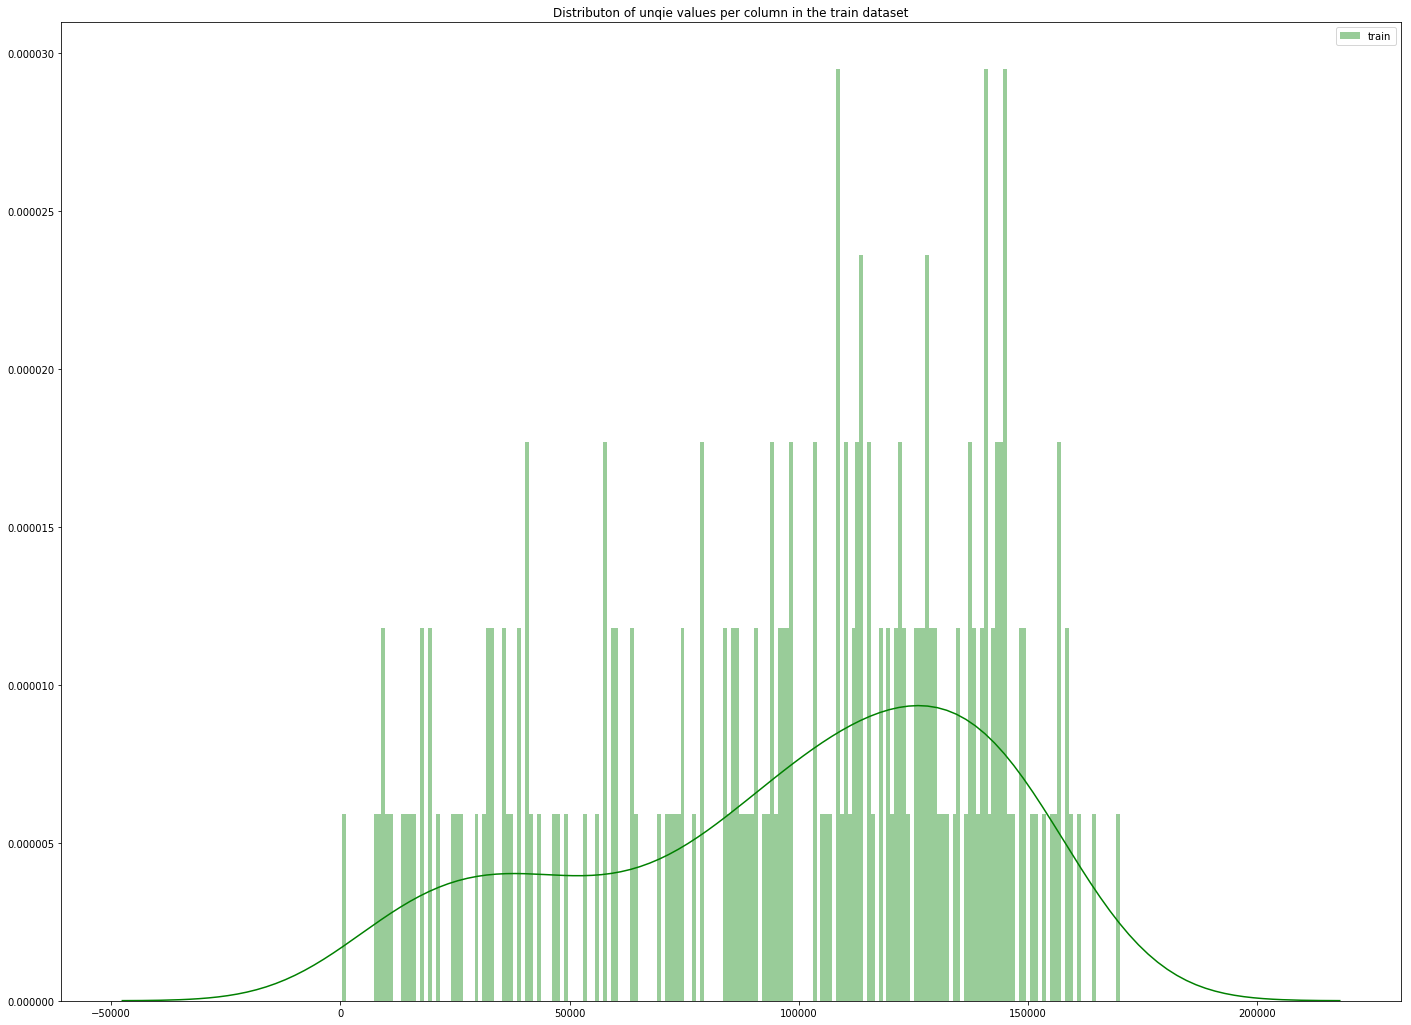

In [23]:
plt.figure(figsize=(24, 18))
plt.title("Distributon of unqie values per column in the train dataset")
#sns.distplot(train_df_id_droped[train_df_id_droped.columns.drop('target').tolist()].unique(), color='green', kde=True, bins=200, label="train")
sns.distplot(uniques_counts_series.values.astype(np.int64), color='green', kde=True, bins=200, label="train")
plt.legend()
plt.show()

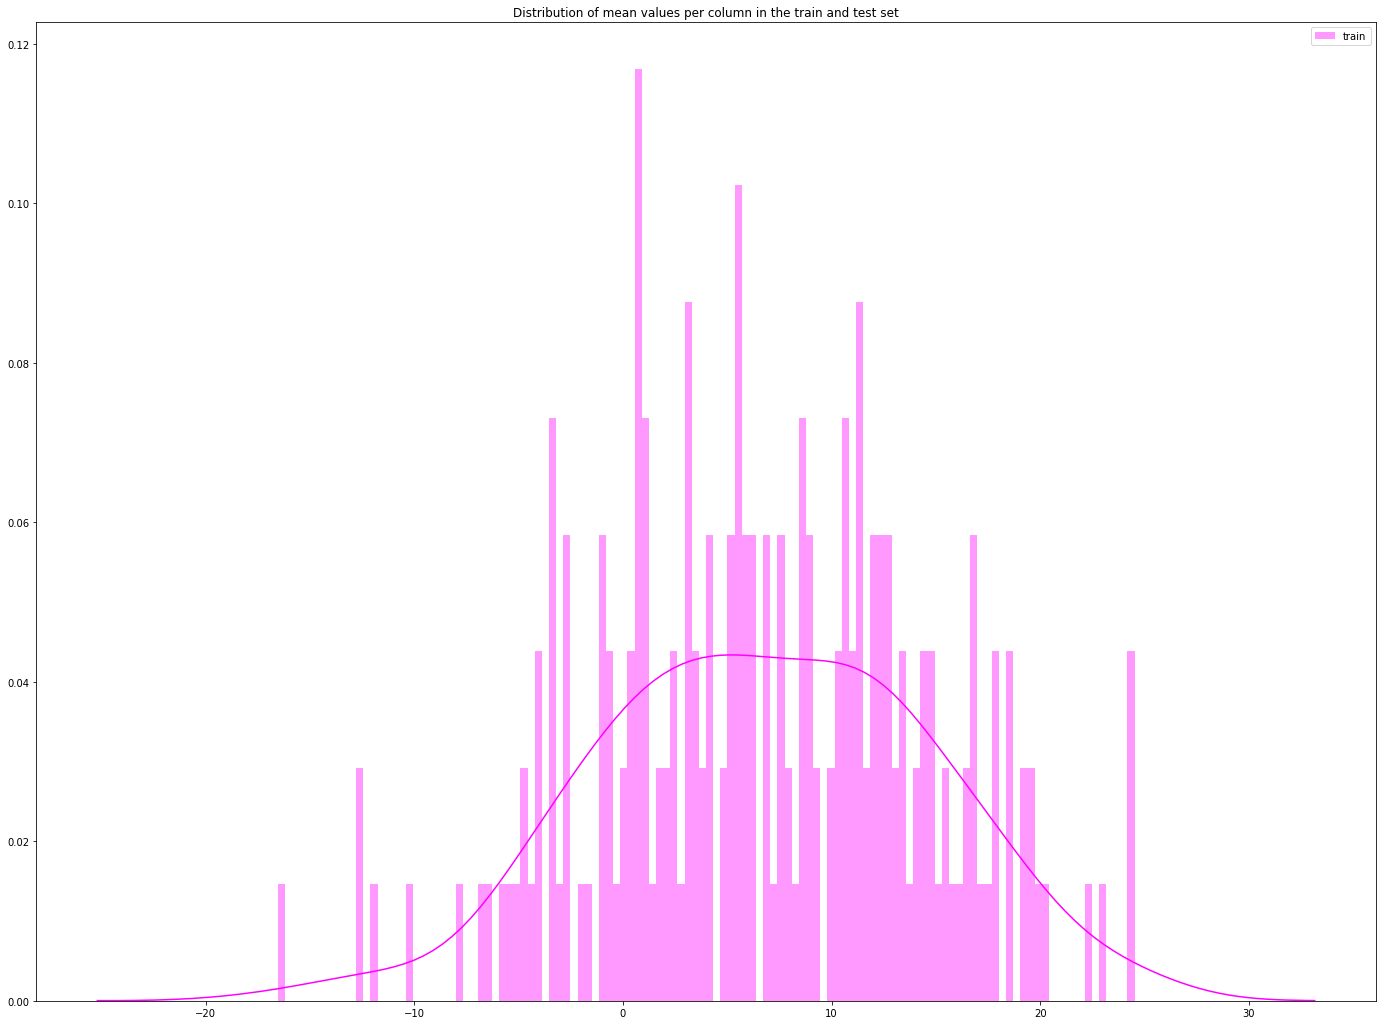

In [24]:
features = train_df.columns.values[2:202]
plt.figure(figsize=(24, 18))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0), color="magenta", kde=True,bins=120, label='train')
#sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

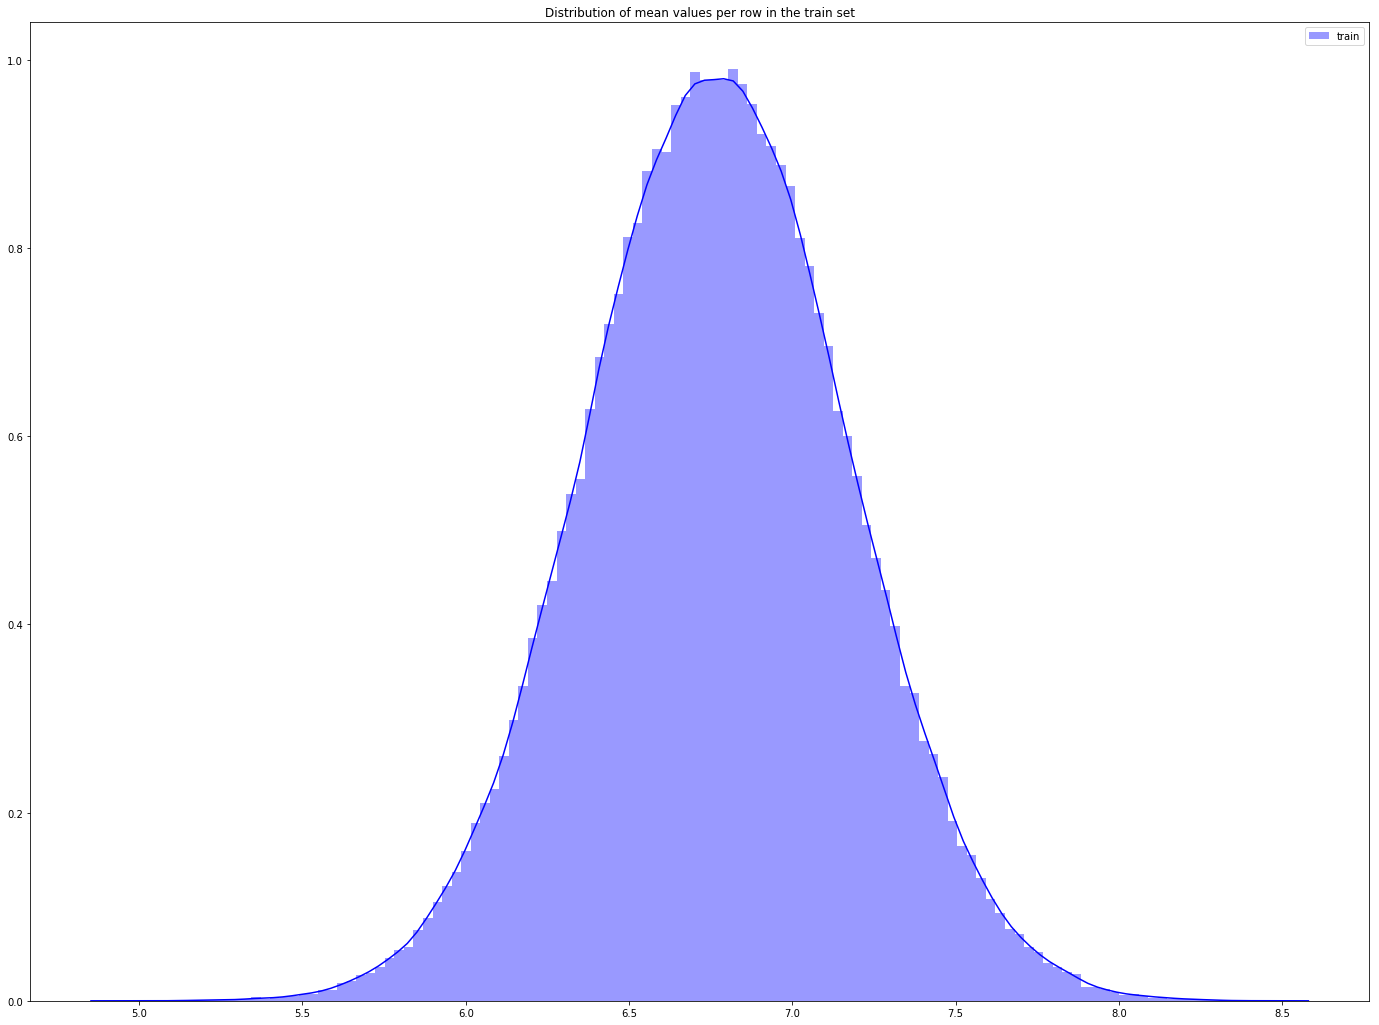

In [25]:
plt.figure(figsize=(24, 18))
features = train_df.columns.values[2:202]
#plt.title("Distribution of mean values per row in the train and test set")
plt.title("Distribution of mean values per row in the train set")
sns.distplot(train_df[features].mean(axis=1), color="blue", kde=True, bins=120, label='train')
#sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

In [26]:
features = [c for c in train_df.columns if c not in ['ID_code', 'target']]
target = train_df['target']

In [27]:
param = {
    'bagging_freq': 5,
    'bagging_fraction': 0.4,
    'boost_from_average':'false',
    'boost': 'gbdt',
    'feature_fraction': 0.05,
    'learning_rate': 0.01,
    'max_depth': -1,  
    'metric':'auc',
    'min_data_in_leaf': 80,
    'min_sum_hessian_in_leaf': 10.0,
    'num_leaves': 13,
    'num_threads': 8,
    'tree_learner': 'serial',
    'objective': 'binary', 
    'verbosity': 1
}

In [28]:
'''
folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
oof = np.zeros(len(train_df))
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
    print("Fold {}".format(fold_))
    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
    num_round = 1000000
    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=1000, early_stopping_rounds=3000)
    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
    fold_importance_df = pd.DataFrame()
    fold_importance_df['Feature'] = features
    fold_importance_df['importance'] = clf.feature_importance()
    fold_importance_df['fold'] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
'''

'\nfolds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)\noof = np.zeros(len(train_df))\npredictions = np.zeros(len(test_df))\nfeature_importance_df = pd.DataFrame()\nfor fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):\n    print("Fold {}".format(fold_))\n    trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])\n    val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])\n    num_round = 1000000\n    clf = lgb.train(param, trn_data, num_round, valid_sets=[trn_data, val_data], verbose_eval=1000, early_stopping_rounds=3000)\n    oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)\n    fold_importance_df = pd.DataFrame()\n    fold_importance_df[\'Feature\'] = features\n    fold_importance_df[\'importance\'] = clf.feature_importance()\n    fold_importance_df[\'fold\'] = fold_ + 1\n    feature_importance_df = pd.concat([feature_import

In [29]:
'''
cols = (feature_importance_df[["Feature", "importance"]]
        .groupby("Feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:150].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(14,28))
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))
plt.title('Features importance (averaged/folds)')
plt.tight_layout()
plt.savefig('FI.png')
'''

'\ncols = (feature_importance_df[["Feature", "importance"]]\n        .groupby("Feature")\n        .mean()\n        .sort_values(by="importance", ascending=False)[:150].index)\nbest_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]\n\nplt.figure(figsize=(14,28))\nsns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False))\nplt.title(\'Features importance (averaged/folds)\')\nplt.tight_layout()\nplt.savefig(\'FI.png\')\n'

In [30]:
min_max_scaler = MinMaxScaler()

In [31]:
train_df_rows_count = train_df.shape[0]

In [32]:
train_df_rows_count

200000

In [33]:
uniques_count_more_1_2 = uniques_counts_series[uniques_counts_series > train_df_rows_count / 2]

In [34]:
uniques_count_more_1_2.shape

(110,)

In [35]:
uniques_count_more_1_4_less_1_2 = uniques_counts_series[uniques_counts_series < train_df_rows_count / 2]

In [36]:
#uniques_count_less_1_2_more_1_4 = uniques_counts_series[
#    ((uniques_counts_series < train_df_rows_count / 2).bool() and (uniques_counts_series > train_df_rows_count / 4).bool()).bool()
#]

In [37]:
uniques_count_less_1_2_more_1_4 = uniques_count_less_1_2_more_1_4[uniques_count_less_1_2_more_1_4 > train_df_rows_count / 4]

In [38]:
uniques_count_more_1_4_less_1_2.shape

(51,)

In [39]:
uniques_count_less_1_4 = uniques_counts_series[uniques_counts_series < train_df_rows_count / 4]

In [40]:
uniques_count_less_1_4.shape

(39,)

In [41]:
uniques_count_less_1_4.head()

var_6     38599
var_9     49417
var_12     9561
var_15    19810
var_23    24913
dtype: int64

In [42]:
#uniques_count_less_1_4.index.tolist()

['var_6',
 'var_9',
 'var_12',
 'var_15',
 'var_23',
 'var_25',
 'var_28',
 'var_34',
 'var_42',
 'var_43',
 'var_50',
 'var_53',
 'var_57',
 'var_59',
 'var_66',
 'var_68',
 'var_71',
 'var_91',
 'var_93',
 'var_95',
 'var_98',
 'var_103',
 'var_105',
 'var_108',
 'var_111',
 'var_114',
 'var_125',
 'var_126',
 'var_130',
 'var_131',
 'var_133',
 'var_144',
 'var_148',
 'var_156',
 'var_161',
 'var_166',
 'var_169',
 'var_189',
 'var_197']

In [94]:
def train(train_df, test_df, target, features, param, num_round=1000000):
    start_time = time.time()
    folds = StratifiedKFold(n_splits=10, shuffle=False, random_state=44000)
    oof = np.zeros(len(train_df))
    predictions = np.zeros(len(test_df))
    feature_importance_df = pd.DataFrame()
    lgb_classifier = None
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_df.values, target.values)):
        print("Fold {}".format(fold_))
        trn_data = lgb.Dataset(train_df.iloc[trn_idx][features], label=target.iloc[trn_idx])
        val_data = lgb.Dataset(train_df.iloc[val_idx][features], label=target.iloc[val_idx])
        num_round = num_round
        clf = lgb.train(
            param,
            trn_data,
            num_round,
            valid_sets=[trn_data, val_data],
            verbose_eval=1000,
            early_stopping_rounds=3000
        )
        lgb_classifier = clf
        oof[val_idx] = clf.predict(train_df.iloc[val_idx][features], num_iteration=clf.best_iteration)
        fold_importance_df = pd.DataFrame()
        fold_importance_df['Feature'] = features
        fold_importance_df['importance'] = clf.feature_importance()
        fold_importance_df['fold'] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        predictions += clf.predict(test_df[features], num_iteration=clf.best_iteration) / folds.n_splits
    print("Total run time {} min:".format((time.time() - start_time) / 60))
    print("CV score: {:<8.5f}".format(roc_auc_score(target, oof)))
    return oof, predictions, feature_importance_df, clf

In [44]:
#train_results_more_1_2 = train(train_df, test_df, uniques_count_more_1_2.index.tolist(), param)

In [45]:
#train_results_less_1_2_more_1_4 = train(train_df, test_df, uniques_count_less_1_2_more_1_4.index.tolist(), param)

In [46]:
#train_results_less_1_4 = train(train_df, test_df, uniques_count_less_1_4.index.tolist(), param)

In [47]:
#oof_more_1_2, predictions_more_1_2, importance_df_more_1_2  = train_results_more_1_2

In [48]:
#predictions_more_1_2.shape

In [49]:
#predictions_more_1_2[:10]

In [50]:
#predictions_more_1_2.max()

In [51]:
#predictions_more_1_2.min()

In [52]:
#df = pd.DataFrame({'var0': [1, 2], 'var1': [3, 4], 'var2': [5, 6], 'var3': [7, 8]})

In [53]:
#df

In [54]:
polinomial_features_maker = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

In [55]:
#new_features = polinomial_features_maker.fit_transform(df)

In [56]:
#new_features

In [57]:
#new_features.shape

In [58]:
#polinomial_features_maker.get_feature_names(['var0', 'var1', 'var2', 'var3'])

In [59]:
def normalise_feature_name(feature_name):
    if '^' in feature_name:
        return '_'.join(feature_name.split('^'))
    elif ' ' in feature_name:
        return '_'.join(feature_name.split())
    else:
        return feature_name

In [60]:
#normalised_feature_names = [normalise_feature_name(feature_name) for feature_name in polinomial_features_maker.get_feature_names(['var0', 'var1', 'var2', 'var3'])]

In [61]:
#normalised_feature_names

In [62]:
target_values = train_df['target'].values

In [63]:
'''
train_values, holdout_test_values, train_target_values, holdout_test_target_values = train_test_split(
    #scaled_train_values,
    train_df[train_df.columns.drop(['ID_code', 'target'])].values,
    target_values,
    test_size=0.2,
    random_state=0
)
'''

"\ntrain_values, holdout_test_values, train_target_values, holdout_test_target_values = train_test_split(\n    #scaled_train_values,\n    train_df[train_df.columns.drop(['ID_code', 'target'])].values,\n    target_values,\n    test_size=0.2,\n    random_state=0\n)\n"

In [64]:
#feature_names = train_df.columns.drop(['ID_code', 'target']).tolist()

In [65]:
#polinomial_train_values = polinomial_features_maker.fit_transform(train_values)

In [66]:
#polinomial_holdout_test_values = polinomial_features_maker.fit_transform(holdout_test_values)

In [67]:
#polinomial_features_names = [normalise_feature_name(feature_name) for feature_name in polinomial_features_maker.get_feature_names(feature_names)]

In [68]:
train_df_uniques_count_more_1_2 = train_df[uniques_count_more_1_2.index]

In [69]:
train_df_uniques_count_more_1_4_less_1_2 = train_df[uniques_count_more_1_4_less_1_2.index]

In [70]:
train_df_uniques_count_less_1_4 = train_df[uniques_count_less_1_4.index]

In [71]:
'target' in train_df_uniques_count_less_1_4.columns.tolist()

False

In [72]:
polinomial_values_uniques_count_more_1_2 = polinomial_features_maker.fit_transform(train_df_uniques_count_more_1_2)

In [73]:
#del polinomial_values_uniques_count_more_1_2

In [74]:
#gc.collect()

In [80]:
polinomial_feature_names_uniques_count_more_1_2 = [normalise_feature_name(feature_name) for feature_name in polinomial_features_maker.get_feature_names(train_df_uniques_count_more_1_2.columns.tolist())]

In [81]:
len(polinomial_feature_names_uniques_count_more_1_2)

6215

In [77]:
train_polinomial_values_ucm_1_2, holdout_test_polinomial_values_ucm_1_2, train_target_values_ucm_1_2, holdout_test_target_values_ucm_1_2 = train_test_split(
    #scaled_train_values,
    polinomial_values_uniques_count_more_1_2,
    target_values,
    test_size=0.2,
    random_state=0
)

In [82]:
train_polinomial_df_ucm_1_2 = pd.DataFrame(data=train_polinomial_values_ucm_1_2, columns=polinomial_feature_names_uniques_count_more_1_2)

In [93]:
train_target_df_ucm_1_2 = pd.DataFrame(data=train_target_values_ucm_1_2, columns=['target'])

In [84]:
train_polinomial_df_ucm_1_2.shape

(160000, 6215)

In [83]:
train_polinomial_df_ucm_1_2.head()

,var_1,var_5,var_7,var_10,var_11,var_13,var_17,var_18,var_19,var_20,...,var_190_2,var_190_var_193,var_190_var_196,var_190_var_199,var_193_2,var_193_var_196,var_193_var_199,var_196_2,var_196_var_199,var_199_2
0,-1.4003,-15.1480,23.0011,-12.8277,-11.9705,0.9585,-13.7352,8.9064,0.6980,2.9975,...,97.253127,103.938373,63.965945,-21.822956,111.083168,68.363007,-23.323081,42.072088,-14.353533,4.896926
1,-2.3055,-3.9362,20.1087,-2.1613,2.0213,12.1363,-11.3936,2.4146,12.2082,18.9734,...,0.180540,-1.965332,-0.716424,7.052490,21.394325,7.798887,-76.772389,2.842933,-27.985888,275.493604
2,2.0901,-19.5462,16.8970,-9.5860,-2.1832,8.4016,-3.2487,11.4263,13.9954,15.6798,...,1.587348,8.172215,-1.094097,13.587014,42.073385,-5.632790,69.950635,0.754119,-9.364999,116.298970
3,1.8913,-14.9898,21.2463,7.0288,2.4824,-0.0570,-5.4731,7.6422,12.2217,4.5632,...,138.525838,105.143438,-12.135738,70.626439,79.805636,-9.211229,53.606653,1.063167,-6.187322,36.008400
4,2.1761,-17.0776,16.8110,4.6831,-2.1157,16.5910,-8.8183,23.8480,23.7098,15.3342,...,16.612961,36.816790,20.045684,-83.176076,81.591476,44.424214,-184.330543,24.187708,-100.362683,416.437486


In [85]:
test_values_ucm_1_2 = polinomial_features_maker.fit_transform(test_df[uniques_count_more_1_2.index])

In [86]:
test_polinomial_df_ucm_1_2 = pd.DataFrame(data=test_values_ucm_1_2, columns=polinomial_feature_names_uniques_count_more_1_2)

In [ ]:
train_results_polinomial_ucm_1_2 = train(
    train_polinomial_df_ucm_1_2,
    test_polinomial_df_ucm_1_2,
    train_target_df_ucm_1_2,
    train_polinomial_df_ucm_1_2.columns.tolist(),
    param
)

Fold 0


In [ ]:
polinomial_values_uniques_count_more_1_4_less_1_2 = polinomial_features_maker.fit_transform(train_df_uniques_count_more_1_4_less_1_2)

In [ ]:
len(polinomial_values_uniques_count_more_1_4_less_1_2)

In [ ]:
polinomial_feature_names_uniques_count_more_1_4_less_1_2 = [normalise_feature_name(feature_name) for feature_name in polinomial_features_maker.get_feature_names(train_df_uniques_count_more_1_4_less_1_2.columns.tolist())]

In [ ]:
train_polinomial_values_ucm_1_4_1_2, holdout_test_polinomial_values_ucm_1_4_1_2, train_target_values_ucm_1_4_1_2, holdout_test_target_values_ucm_1_4_1_2 = train_test_split(
    #scaled_train_values,
    polinomial_values_uniques_count_more_1_4_less_1_2,
    target_values,
    test_size=0.2,
    random_state=0
)

In [ ]:
train_polinomial_df_ucm_1_4_1_2 = pd.DataFrame(data=train_polinomial_values_ucm_1_4_1_2, columns=polinomial_feature_names_uniques_count_more_1_4_less_1_2)

In [ ]:
train_target_df_ucm_1_4_1_2 = pd.DataFrame(data=train_target_values_ucm_1_4_1_2, columns=['target'])

In [ ]:
train_polinomial_df_ucm_1_4_1_2.shape

In [ ]:
train_polinomial_df_ucm_1_4_1_2.head

In [ ]:
test_values_ucm_1_4_1_2 = polinomial_features_maker.fit_transform(test_df[uniques_count_more_1_4_less_1_2.index])

In [ ]:
test_polinomial_df_ucm_1_4_1_2 = pd.DataFrame(data=test_values_ucm_1_4_1_2, columns=polinomial_feature_names_uniques_count_more_1_4_less_1_2)

In [ ]:
train_results_polinomial_ucm_1_4_1_2 = train(
    train_polinomial_df_ucm_1_4_1_2,
    test_polinomial_df_ucm_1_4_1_2,
    train_target_df_ucm_1_4_1_2,
    train_polinomial_df_ucm_1_4_1_2.columns.tolist(),
    param
)

In [ ]:
polinomial_values_uniques_count_less_1_4 = polinomial_features_maker.fit_transform(train_df_uniques_count_less_1_4)

In [ ]:
len(polinomial_values_uniques_count_more_1_4_less_1_2)

In [ ]:
polinomial_feature_names_uniques_count_1_4 = [normalise_feature_name(feature_name) for feature_name in polinomial_features_maker.get_feature_names(train_df_uniques_count_less_1_4.columns.tolist())]

In [ ]:
train_polinomial_values_ucm_1_4, holdout_test_polinomial_values_ucm_1_4, train_target_values_ucm_1_4, holdout_test_target_values_ucm_1_4 = train_test_split(
    #scaled_train_values,
    polinomial_values_uniques_count_less_1_4,
    target_values,
    test_size=0.2,
    random_state=0
)

In [ ]:
train_polinomial_df_ucm_1_4 = pd.DataFrame(data=train_polinomial_values_ucm_1_4, columns=polinomial_feature_names_uniques_count_less_1_4)

In [ ]:
train_target_df_ucm_1_4 = pd.DataFrame(data=train_target_values_ucm_1_4, columns=['target'])

In [ ]:
train_polinomial_df_ucm_1_4.shape

In [ ]:
train_polinomial_df_ucm_1_4.shape

In [ ]:
test_values_ucm_1_4 = polinomial_features_maker.fit_transform(test_df[uniques_count_less_1_4.index])

In [ ]:
test_polinomial_df_ucm_1_4 = pd.DataFrame(data=test_values_ucm_1_4, columns=polinomial_feature_names_uniques_count_less_1_4)

In [ ]:
train_results_polinomial_ucm_1_4 = train(
    train_polinomial_df_ucm_1_4,
    test_polinomial_df_ucm_1_4,
    train_target_df_ucm_1_4,
    train_polinomial_df_ucm_1_4.columns.tolist(),
    param
)